In [24]:
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

# Process the training data

In [25]:
loss_data_dir = join(getcwd(), "loss_data", "train")

kl_loss_path = join(loss_data_dir, "run-.-tag-kl_loss.csv")
recon_loss_path = join(loss_data_dir, "run-.-tag-loss.csv")
general_loss_path = join(loss_data_dir, "run-.-tag-recon_loss.csv")

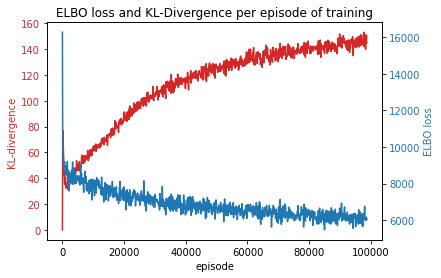

In [8]:
# Plot the combined ELBO loss and KL divergence of the VNCA model during training
general_loss = np.genfromtxt(general_loss_path, skip_header=1, delimiter=",")
kl_loss = np.genfromtxt(kl_loss_path, skip_header=1, delimiter=",")

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(kl_loss[:,1], kl_loss[:,2], color=color)
ax1.set_ylabel("KL-divergence", color=color)
ax1.set_xlabel("episode")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("ELBO loss", color=color) 
ax2.plot(general_loss[:,1], general_loss[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title("ELBO loss and KL-Divergence per episode of training")
plt.savefig(join(loss_data_dir, "elbo_kl_plot.png"))
plt.show()


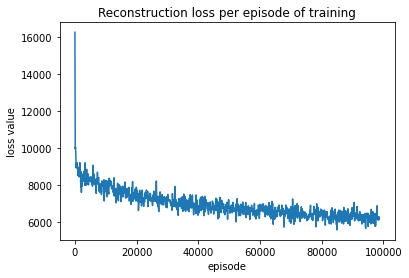

In [20]:
recon_loss = np.genfromtxt(recon_loss_path, skip_header=1, delimiter=",")
plt.plot(recon_loss[:,1], recon_loss[:,2])
plt.title("Reconstruction loss per episode of training")
plt.ylabel("loss value")
plt.xlabel("episode")
plt.savefig(join(loss_data_dir, "recon_plot.png"))
plt.show()

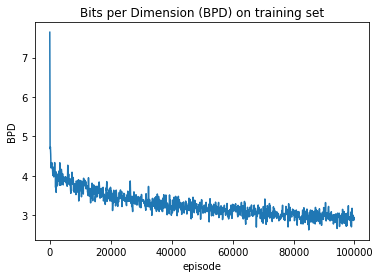

In [29]:
# Plot the Bits per Dimension on the training set during training
bpd_loss_val = np.genfromtxt(join(loss_data_dir, "run-.-tag-bpd.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_loss_val[:,1], bpd_loss_val[:,2])
plt.title("Bits per Dimension (BPD) on training set")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(loss_data_dir, "bpd_plot.png") )
plt.show()

# Process the validation data

In [27]:
data_dir = join(getcwd(), "loss_data", "test")

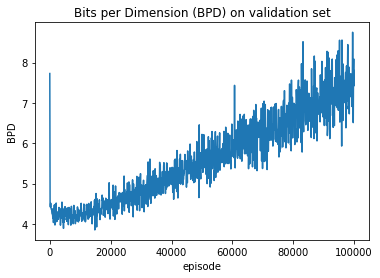

In [28]:
# Plot the Bits per Dimension on the validation set during training
bpd_loss_val = np.genfromtxt(join(data_dir, "bpd-loss.csv"), skip_header=1, delimiter=",")
plt.plot(bpd_loss_val[:,1], bpd_loss_val[:,2])
plt.title("Bits per Dimension (BPD) on validation set")
plt.ylabel("BPD")
plt.xlabel("episode")
plt.savefig(join(data_dir, "bpd_plot.png") )
plt.show()

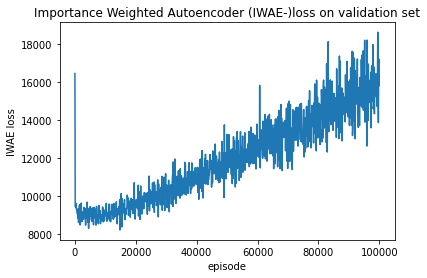

In [18]:
# Plot the IWAE loss on the validation set during training
iwae_loss_val = np.genfromtxt(join(data_dir, "total-loss.csv"), skip_header=1, delimiter=",")
plt.plot(iwae_loss_val[:,1], iwae_loss_val[:,2])
plt.title("Importance Weighted Autoencoder (IWAE-)loss on validation set")
plt.ylabel("IWAE loss")
plt.xlabel("episode")
plt.savefig(join(data_dir, "iwae_plot.png") )
plt.show()

In [65]:
from loss import elbo
from init import init_vnca

In [66]:
vnca = init_vnca()

VNCA(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ELU(alpha=1.0)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): ELU(alpha=1.0)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=512, bias=True)
  )
  (nca): NCA(
    (update_net): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Residual(
        (delegate): Sequential(
          (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ELU(alpha=1.0)
          (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
 

In [67]:
param_path = join(getcwd(), "latest")
vnca.load(param_path)

# Plotting growth of samples

In [68]:
samples = vnca.p_z.sample((8,)).view(8, -1, 1, 1).expand(8, -1, vnca.h, vnca.w).to(vnca.device)
states = vnca.decode(samples)
print(len(states))

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


129


In [71]:
def plot_growth(save_path, states, mean=False):
    num_rows = 5
    num_cols = 27

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols/2,num_rows/2),
                            gridspec_kw={'wspace':0, 'hspace':0},
                            squeeze=True)
    cur_row = 0
    for idx, state in enumerate(states):
        if idx % num_cols == 0 and idx > 0:
            cur_row += 1
        growth_sample, growth_mean = vnca.to_rgb(state[0:1])
        if mean:
            axs[cur_row][idx % num_cols].imshow(growth_mean.squeeze(0).permute(1,2,0).cpu().detach().numpy(), aspect='auto')
        else:
            axs[cur_row][idx % num_cols].imshow(growth_sample.squeeze(0).permute(1,2,0).cpu().detach().numpy(), aspect='auto')
        axs[cur_row][idx % num_cols].axis('off')

    for row in range(num_rows):
        for col in range(num_cols):
            axs[row][col].axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
    plt.savefig(save_path)


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


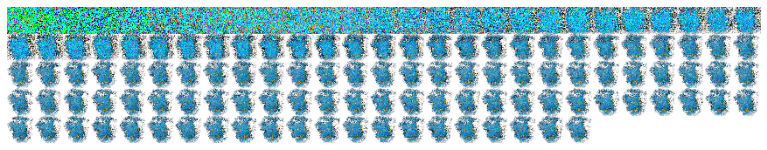

<Figure size 432x288 with 0 Axes>

In [72]:
plot_growth(join(data_dir, "growth_custom.png"), states)

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


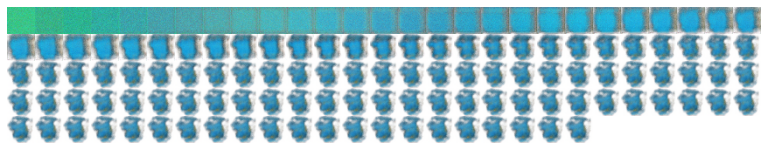

<Figure size 432x288 with 0 Axes>

In [73]:
plot_growth(join(data_dir, "growth_custom.png"), states, mean=True)

In [22]:
samples = vnca.p_z.sample((8,)).view(8, -1, 1, 1).expand(8, -1, vnca.h, vnca.w).to(vnca.device)
states = vnca.decode(samples)
samples, samples_means = vnca.to_rgb(states[-1])

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'dml.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


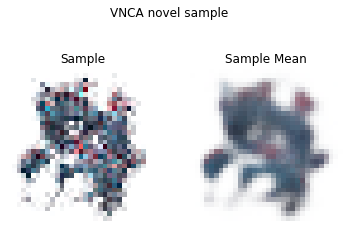

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('VNCA novel sample')
ax1.imshow(samples[0].permute(1, 2, 0).cpu().detach())
ax1.axis('off')
ax1.title.set_text("Sample")
ax2.imshow(samples_means[0].permute(1,2,0).cpu().detach())
ax2.axis('off')
ax2.title.set_text("Sample Mean")

# Visualisation of an original image and its downscaled version

In [ ]:
from PIL import Image
import os
import torch as t
from skimage import io
from data import PokemonIMG
import matplotlib.image as mpimg

In [4]:
def to_alpha(x):
  return t.clip(x[3:4,...], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[:3,...], to_alpha(x)
  return 1.0-a+rgb

(256, 256, 4)
torch.Size([4, 32, 32])
torch.Size([3, 32, 32])


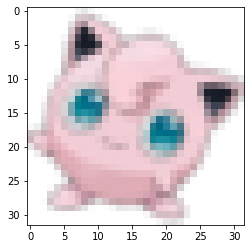

In [22]:
dset = PokemonIMG()

img_name = os.path.join(os.getcwd(), "pokemon", "39.png")
print(io.imread(img_name).shape)
image = dset.transform(Image.fromarray(io.imread(img_name)))
image[:3,...] *= image[3:,...]
print(image.shape)
image = to_rgb(image)
print(image.shape)

plt.imshow(image.permute(1, 2, 0))

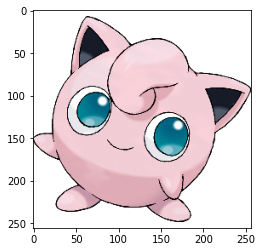

In [23]:
original = mpimg.imread(img_name)
plt.imshow(original)